In [1]:
%%writefile task1.py
from mpi4py import MPI
import numpy as np
import time
import sys
comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()

time0 = time.time()

def get_evolution_matrix(N_iter, rs, xs):
    """
    From r_list,x_list, make tensor M_i = M[r_j,x_k,time_i]
    and make evolution of whole matrix as M_i = rs * M_(i-1) * (1-M_(i-1))
    return tensor M_i = M[r_j,x_k,time_i]
    """
    mat = np.zeros((xs.shape[0], rs.shape[0], N_iter)) # float by default
    mat[:, :, 0] = np.meshgrid(rs, xs)[1]
    for t in range(1, N_iter):
        mat[:, :, t] = rs * mat[:, :, t - 1] * (1 - mat[:, :, t - 1])
    return mat

def get_last_m(mat, m, n):
    """
    From tensor M take elements from time_n to time_(n + m)

    """
    return mat[:, :, n : n + m]

N_iter = 100
resolution = int(sys.argv[1])
rs_total = np.linspace(0, 4, resolution) # float by default

r_step = (resolution//size)

if rank == size-1:
    rs =rs_total[r_step * rank:]
else:
    rs = rs_total[r_step * rank:r_step * (rank+1)]


xs = np.linspace(0.001, 1, resolution,endpoint=False) # float by default


mat = get_evolution_matrix(N_iter, rs, xs)
m = 10
last_mat = get_last_m(mat, m, N_iter - m)

img = np.zeros((last_mat.shape[0], last_mat.shape[1]),dtype=np.uint64) + 1
### to img_pixel_jk add + 1 when mat converge to x_j, r_k 
for t in range(m):
    for r_ind, r in enumerate(rs):
        for x in last_mat[:, r_ind, t]:
            img[int(x * xs.shape[0]), r_ind] += 1


amode = MPI.MODE_WRONLY|MPI.MODE_CREATE
fh_result = MPI.File.Open(comm,f"./img_proc_{size}_res{resolution}.txt", amode)
offset =  comm.Get_rank() * resolution * r_step * 8
fh_result.Write_at_all(offset, img.T.flatten())

fh_timer = MPI.File.Open(comm, f"./time_proc_{size}_res{resolution}.txt", amode)
timer = np.array([time.time() - time0],dtype= np.float32)

offset =  comm.Get_rank() * 4
fh_timer.Write_at_all(offset, timer)

MPI.Finalize()

Overwriting task1.py


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

plt.rcParams["figure.figsize"] = (15, 7)

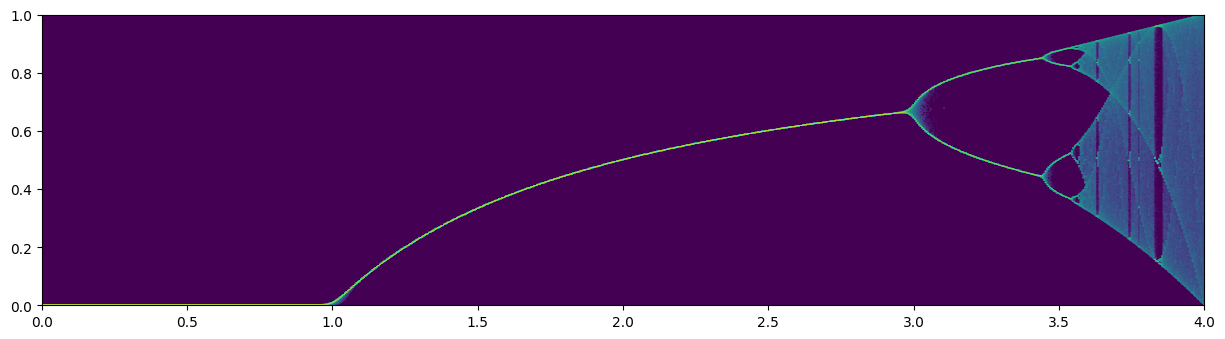

In [3]:
!mpirun -n 8 python task1.py 800
x = np.fromfile("img_proc_8_res800.txt", dtype=np.uint64)
shape = int(np.sqrt(x.shape[0]))
x = x.reshape(shape, shape).T
plt.imshow(
    x,
    norm=matplotlib.colors.LogNorm(),
    extent=[0, 4, 1, 0],
)
plt.gca().invert_yaxis()

In [4]:
for proc in range(1,8):
    resolution = 200
    !mpirun -n {proc} python task1.py {resolution}

speedup = []
for proc in range(1,8):
    speedup.append(np.mean(np.fromfile(f"time_proc_{proc}_res200.txt", dtype=np.float32)))

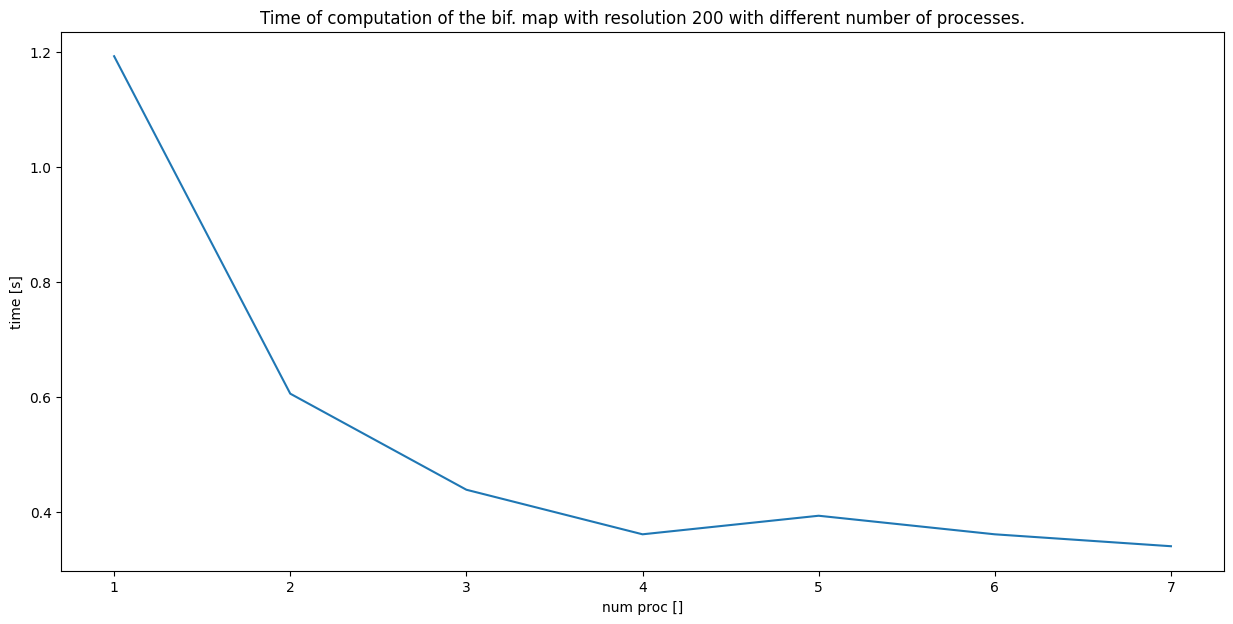

In [5]:
plt.plot(range(1, 8), speedup)
plt.title(
    "Time of computation of the bif. map with resolution 200 with different number of processes."
)
plt.xlabel("num proc []")
plt.ylabel("time [s]")
plt.show()